# Naive Classifier for Fake news recognition

## Packages

In [76]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)

## Reading the data

In [47]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'
# train2.filename <- 'dataset/fake-news/train.csv'
# test2.filename <- 'dataset/fake-news/test.csv'

In [48]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

In [49]:
head(test.df)

,Text,Text_Tag
,<chr>,<chr>
1,Building a wall on the U.S.-Mexico border will take literally years.,immigration
2,Wisconsin is on pace to double the number of layoffs this year.,jobs
3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"
6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement"


In [50]:
head(train.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


In [51]:
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [52]:
perc_split<- 0.8  # set splitting percentages
n_rows<- nrow(train.df)
n_rows_train<-floor(n_rows*perc_split)

In [53]:
# splitting the datasets
train.df.train<-train.df[1:n_rows_train,]
train.df.validation<- train.df[n_rows_train+1:n_rows,]

In [54]:
nrow(train.df.train)
nrow(train.df)

[1] 8192

[1] 10240

In [109]:
train.df.train %>%select(Text) %>% unnest_tokens(word, Text) %>% anti_join(get_stopwords(), by = join_by(word)) %>% unique %>% arrange(word) #%>% filter(grepl("", word))

word
<chr>
0
0.05
0.1
0.25
0.3
0.4
0.47
0.7
0.9


In [73]:
stop_words<-stopwords('en')

In [68]:
tokenize<- function(msg, stop_words){
    msg %>% str_to_lower %>% str_split(' ') -> msg
    return(msg)
    }

In [69]:
tokenize(train.df.train[1,2])

[[1]]
 [1] "says"         "of"           "flood"        "of"           "non-mexicans"
 [6] "being"        "apprehended"  "at"           "the"          "border:"     
[11] "these"        "are"          "people"       "that"         "are"         
[16] "coming"       "from"         "states"       "like"         "syria"       
[21] "that"         "have"         "substantial"  "connections"  "back"        
[26] "to"           "terrorist"    "regimes"      "and"          "terrorist"   
[31] "operations."

In [55]:
train.df %>% select(Text_Tag) %>% unique %>% summarise(n())

n()
<int>
3828


In [110]:
train.df  %>% filter(grepl('06', Text)) #%>% summarise(n())

Labels,Text,Text_Tag
<int>,<chr>,<chr>
0,"I have cut taxes 63 times, including a 2006 property tax reduction that ranks as the largest in state history.","candidates-biography,education,small-business,taxes"
3,Annual water usage in 2010 was actually down more than 18 percent from usage in 2006.,water
3,"Says Donald Trump was one of the people who rooted for the housing crisis. He said back in 2006, Gee, I hope it does collapse because then I can go in and buy some and make some money.","economy,history,housing,market-regulation"
3,"By 2006, the American people were overwhelmingly against the Iraq War.","history,iraq,military,polls"
2,"Since Corey Stewart became chairman in November 2006, unemployment is up 150% and average home price sales are down $150,000.","economy,housing,jobs"
0,"In 2006, Arizona had four ballot issues that were ""very tough on illegal immigration... Forty-seven percent of the Hispanics in Arizona voted for them.""",immigration
5,The five economic indicators that the federal government tracks - for the first time since August 2006 - were positive this October.,economy
3,"In 2006, Bernie Sanders voted in the House with hard-line Republicans for indefinite detention for undocumented immigrants, and then he sided with those Republicans to stand with vigilantes known as Minutemen who were taking up outposts along the border to hunt down immigrants.",immigration
3,"Ed Gillespies 2006 book promoted an individual health care mandate, and recommends that it be enforced by the IRS through the income tax code.","medicaid,taxes"


## About the data

In [45]:
colors

function (distinct = FALSE) 
{
    c <- .Call(C_colors)
    if (distinct) 
        c[!duplicated(t(col2rgb(c)))]
    else c
}
<bytecode: 0x56044d91cee0>
<environment: namespace:grDevices>

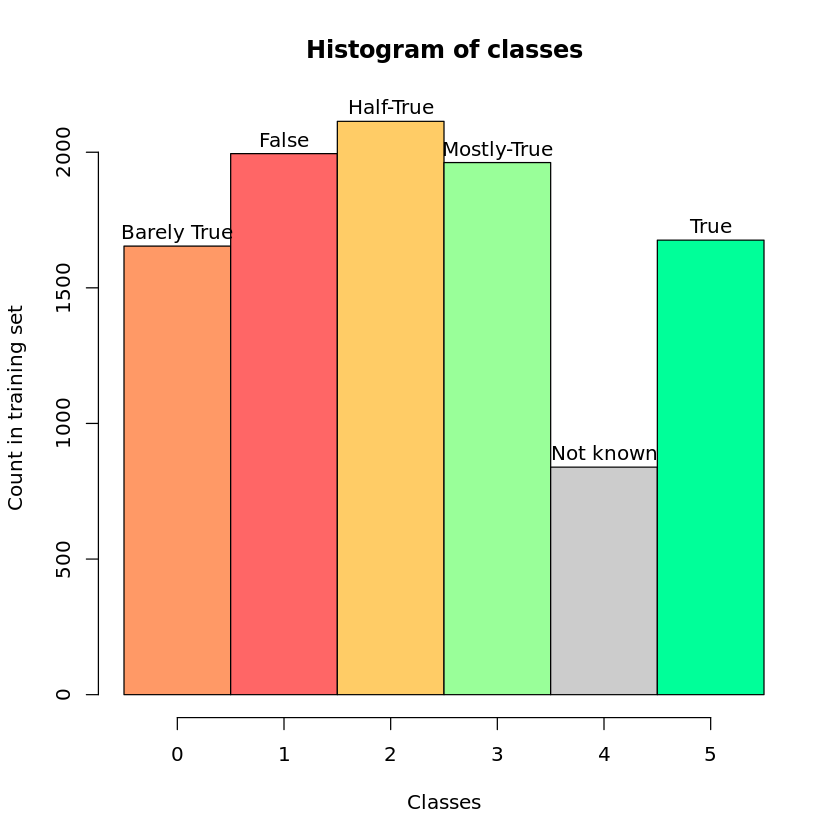

In [46]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF9966', '#FF6666', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

hist(x = train.df$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )